## Trying to generate the electron scattering factors from the DIFFPY program

In [ ]:
import h5py
import numpy as np
from diffpy.srreal.scatteringfactortable import SFTXray

# Function to calculate electron scattering factors
def calculate_electron_scattering_factors(Q_values, fx_values, Z):
    """Calculate electron scattering factors f_e(Q)."""
    me = 9.10938356e-31  # Electron mass in kg
    e = 1.602176634e-19  # Elementary charge in C
    hbar = 1.054571817e-34  # Reduced Planck's constant in J.s
    fe_values = (me * e**2 / (2 * hbar**2)) * ((Z - fx_values) / Q_values**2)
    fe_values[Q_values == 0] = 0  # Avoid division by zero
    return fe_values

# Generate data for all elements
xray_table = SFTXray()

import periodictable

# Create a dictionary with element symbols as keys and atomic numbers as values
element_data = {el.symbol: el.number for el in periodictable.elements if el.number and el.number <= 83}

Q_values = np.linspace(0.5, 50, 10000)  # Common Q-range

# Save data to HDF5
with h5py.File("/home/ABTLUS/victor.secco/data_processing/packages/electron_scattering_data.h5", "w") as hdf:
    for element, Z in element_data.items():
        fx_values = xray_table.lookup(element, Q_values)
        fe_values = calculate_electron_scattering_factors(Q_values, fx_values, Z)
        grp = hdf.create_group(element)
        grp.create_dataset("Q_values", data=Q_values)
        grp.create_dataset("f_e_values", data=fe_values)
    print("Data successfully saved to electron_scattering_data.h5")




In [ ]:
import sys
sys.path.append('/home/ABTLUS/victor.secco/data_processing')
from mypackages.electron_scattering_table import SFTElectron
from diffpy.srreal.scatteringfactortable import SFTXray

# Create an electron scattering table object
electron_table = SFTElectron()
xray_table = SFTXray()
 
# Example lookup
Q_values = np.linspace(0.5, 10, 50)
f_e_values = [electron_table._standardLookup("Cd", Q) for Q in Q_values]
f_x_values = xray_table.lookup("Cd", Q_values)

# Plot the results
import matplotlib.pyplot as plt
plt.plot(Q_values, f_e_values, label="Oxygen Electron $f_e(Q)$")
plt.plot(Q_values, f_x_values, label="Oxygen Electron $f_x(Q)$")
plt.xlabel("$Q$ ($\mathrm{Å}^{-1}$)")
plt.ylabel("Scattering Factor")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Prepare scattering data for both X-ray and electron factors
xray_scattering_data = {}
electron_scattering_data = {}

for element, Z in elements.items():
    print(element, Z)
    fx_values = xray_table.lookup(element, Q_values)  # X-ray scattering factors
    fe_values = calculate_electron_scattering_factors(Q_values, fx_values, Z)  # Electron scattering factors
    
    # Populate dictionaries
    xray_scattering_data[element] = fx_values
    electron_scattering_data[element] = (Q_values, fe_values)  # For custom_table

# Create the custom electron scattering table using MultiElementScatteringFactorTable
custom_table = MultiElementScatteringFactorTable(electron_scattering_data)

# Plot the results
plt.figure(figsize=(10, 8))

for element in elements.keys():
    plt.plot(Q_values, xray_scattering_data[element], '--', label=f"{element} X-ray $f_x(Q)$")
    plt.plot(Q_values, electron_scattering_data[element][1], '-', label=f"{element} Electron $f_e(Q)$")
    plt.plot(Q_values, fe_valuesCd , '-', label=f"{element} Electron $f_e(Q)$")

# Customize the plot
plt.title("Comparison of Electron and X-ray Scattering Factors", fontsize=14)
plt.xlabel("$Q$ ($\mathrm{Å}^{-1}$)", fontsize=12)
plt.ylabel("Scattering Factor", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10, loc='best')
plt.tight_layout()

# Show the plot
plt.show()


## Comparing Lobato and Kirkland parametrizations of the electron scattering factors

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from mypackages.eRDF import *


from mypackages.plot_style import set_plot_style

set_plot_style()

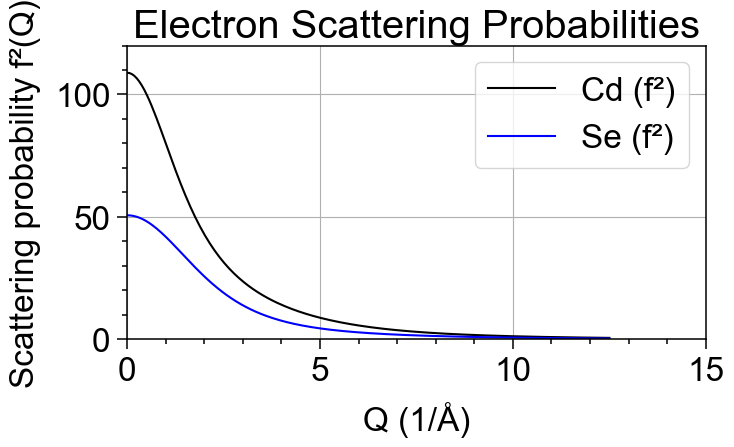

In [2]:

start = 0
end = 200
ds = 0.01  # q sampling step
q0 = 0
region = 0
lobato_path = r"C:\Users\seccolev\data_processing\src\packages\Lobato_2014.txt"  # Update with your actual path

# Dummy intensity data (not used in scattering calculation)
data = np.ones(end - start)

# Define elements: key=index, value=[row_in_Lobato_file, atomic_fraction]
Elements = {
    1: [48, 1],  # Cd at row 48
    2: [34, 1],  # Se at row 34
}

# Initialize DataProcessor
processor = DataProcessor(data, q0, lobato_path, start, end, ds, Elements, region)

# Extract q and scattering probabilities
q = processor.q
scattering_probs = processor.lobato_factors  # shape: (num_elements, len(q))

# Plot
plt.figure(figsize=(8,5))
plt.plot(q, scattering_probs[0]**2, label="Cd (f²)")
plt.plot(q, scattering_probs[1]**2, label="Se (f²)")
plt.xlabel("Q (1/Å)")
plt.ylabel("Scattering probability f²(Q)")
plt.title("Electron Scattering Probabilities")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


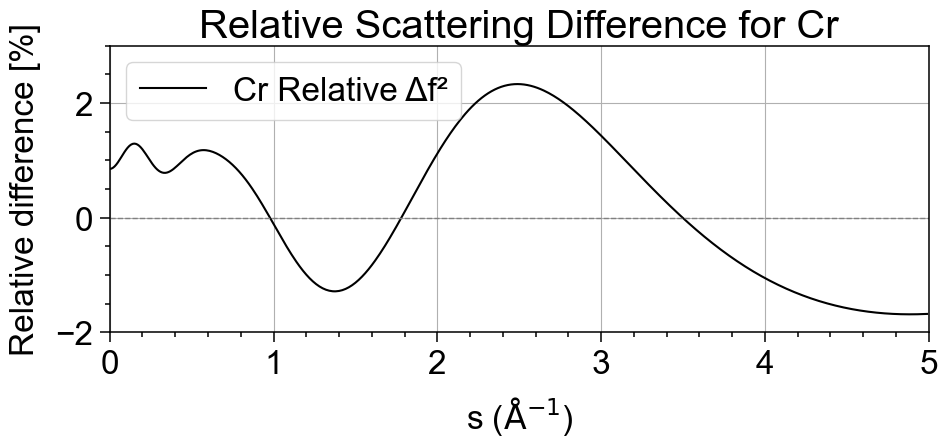

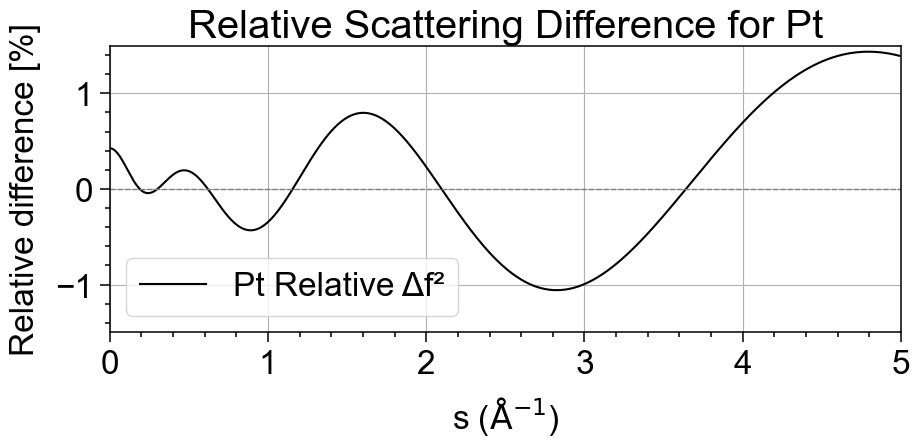

In [10]:
num_elements = 82
s = np.arange(0, 5, 0.01)
s2 = s**2


kirkland_path = r"C:\Users\seccolev\data_processing\src\packages\Kirkland_2010.txt"


# --- Load coefficient tables ---
df_lobato = pd.read_csv(lobato_path, header=None)
df_kirkland = pd.read_csv(kirkland_path, sep=r"[\t ]+", engine="python")

# --- Calculate Lobato f(s)² ---
def calculate_lobato_f2(s2, a, b):
    f = sum(ai * ((s2 * bi + 2) / (s2 * bi + 1)**2) for ai, bi in zip(a, b))
    return f**2

lobato_f2 = []
for i in range(num_elements):
    row = df_lobato.iloc[i].values
    a, b = row[:5], row[5:]
    lobato_f2.append(calculate_lobato_f2(s2, a, b))

# --- Calculate Kirkland f(s)² ---
def calculate_kirkland_f2(s2, coeffs):
    a = coeffs[0:6:2]
    b = coeffs[1:6:2]
    c = coeffs[6:12:2]
    d = coeffs[7:12:2]
    rational = sum(ai / (s2 + bi) for ai, bi in zip(a, b))
    expo = sum(ci * np.exp(-s2 * di) for ci, di in zip(c, d))
    return (rational + expo)**2

kirkland_f2 = []
for i in range(num_elements):
    coeffs = df_kirkland.iloc[i].values
    kirkland_f2.append(calculate_kirkland_f2(s2, coeffs))

# --- Calculate Differences ---
lobato_f2 = np.array(lobato_f2)
kirkland_f2 = np.array(kirkland_f2)
epsilon = 1e-12
relative_difference_f2 = 100 * (lobato_f2 - kirkland_f2) / (kirkland_f2 + epsilon)


# --- Plot differences for selected element indices
def plot_relative_difference(index, label=None):
    plt.figure(figsize=(10, 5))
    plt.plot(s, relative_difference_f2[index], label=f"{label or f'Element {index}'} Relative Δf²")
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.xlabel(r"s ($\mathrm{\AA}^{-1}$)")
    plt.ylabel("Relative difference [%]")
    plt.title(f"Relative Scattering Difference for {label or f'Element {index}'}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_relative_difference(24, "Cr")
plot_relative_difference(78, "Pt")



Elements with relative difference > 5%:
[24, 41, 42, 43, 44, 45, 58, 77, 78, 81]
Elements with relative difference > 5%:
24: Cr
41: Nb
42: Mo
43: Tc
44: Ru
45: Rh
58: Ce
77: Ir
78: Pt
81: Tl


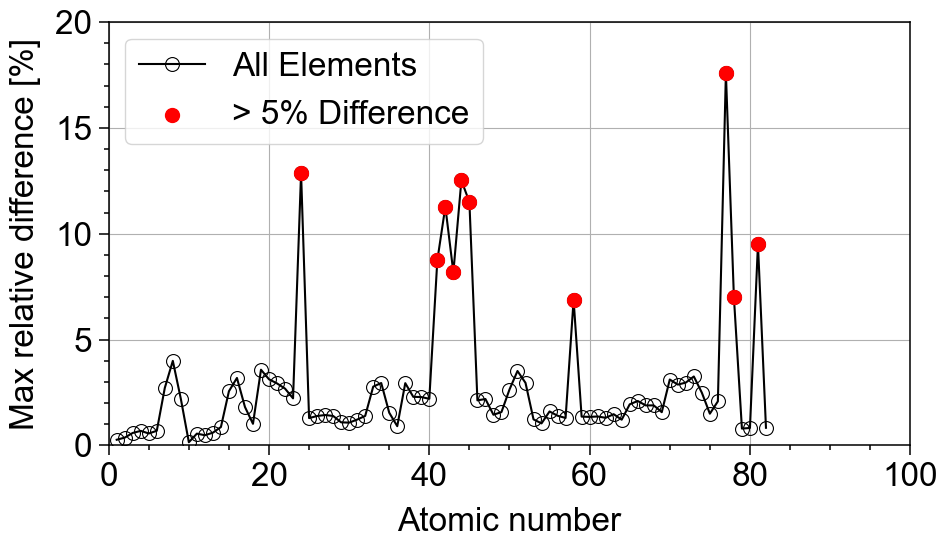

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

max_index = 82  # atomic numbers 1 to 82
s = np.arange(0, 2, 0.01)
s2 = s**2
epsilon = 1e-12
threshold = 5.0  # percent difference threshold

element_symbols = [
    "H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne",
    "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
    "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr",
    "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn",
    "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd",
    "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb",
    "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg",
    "Tl", "Pb"
]


# --- Compute max relative difference ---
max_rel_diff_percent = []
highlight_indices = []

for i in range(max_index):
    lobato_row = df_lobato.iloc[i].values
    kirkland_row = df_kirkland.iloc[i].values
    a, b = lobato_row[:5], lobato_row[5:]
    lobato_f2 = calculate_lobato_f2(s2, a, b)
    kirkland_f2 = calculate_kirkland_f2(s2, kirkland_row)
    rel_diff_percent = 100 * (lobato_f2 - kirkland_f2) / (kirkland_f2 + epsilon)
    max_diff = np.max(np.abs(rel_diff_percent))
    max_rel_diff_percent.append(max_diff)
    if max_diff > threshold:
        highlight_indices.append(i + 1)  # atomic number

# --- Print highlighted atomic numbers ---
print("Elements with relative difference > 5%:")
print(highlight_indices)

# --- Plot ---
atomic_numbers = np.arange(1, max_index + 1)
plt.figure(figsize=(10, 6))
plt.plot(atomic_numbers, max_rel_diff_percent, marker='o', label='All Elements')
plt.scatter(
    highlight_indices,
    [max_rel_diff_percent[i - 1] for i in highlight_indices],
    color='red', label='> 5% Difference', zorder=5
)

print("Elements with relative difference > 5%:")
for i in highlight_indices:
    symbol = element_symbols[i - 1]
    print(f"{i}: {symbol}")


plt.xlabel("Atomic number")
plt.ylabel("Max relative difference [%]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def calculate_kirkland_factor(s2, coeffs):
    """
    Calculates f(s) using Kirkland's formula.

    Parameters:
    - s2: array of s^2 values
    - coeffs: list or array of 12 Kirkland parameters in this order:
      [a1, b1, a2, b2, a3, b3, c1, d1, c2, d2, c3, d3]

    Returns:
    - f(s) evaluated at all s² values
    """
    a = coeffs[0:6:2]  # a1, a2, a3
    b = coeffs[1:6:2]  # b1, b2, b3
    c = coeffs[6:12:2] # c1, c2, c3
    d = coeffs[7:12:2] # d1, d2, d3

    rational_part = sum(ai / (s2 + bi) for ai, bi in zip(a, b))
    exponential_part = sum(ci * np.exp(-s2 * di) for ci, di in zip(c, d))

    return rational_part + exponential_part

# s² values
s = np.arange(0, 2, 0.01)
s2 = s**2

kirkland_path = r"C:\Users\seccolev\data_processing\src\packages\Kirkland_2010.txt"

df_kirkland = pd.read_csv(kirkland_path, sep=r"[\t ]+", engine="python")

KIRKLAND_FACTORS = []
for element in Elements:
    if Elements[element]:
        KIRKLAND_FACTORS.append(np.array(df_kirkland.iloc[Elements[element][0]]))



# Compute f(s)
f_cd = calculate_kirkland_factor(s2, KIRKLAND_FACTORS[0])  # Cd
f_se = calculate_kirkland_factor(s2, KIRKLAND_FACTORS[1])  # Se

# Plot
plt.plot(q, f_cd**2, label="Kirkland Cd f²(s)")
plt.plot(q, f_se**2, label="Kirkland Se f²(s)")
plt.plot(q, scattering_probs[0]**2, label="Lobato Cd (f²)")
plt.plot(q, scattering_probs[1]**2, label="Lobato Se (f²)")
plt.xlabel(r"s ($\mathrm{\AA}^{-1}$)")
plt.ylabel("Scattering probability $f^2(s)$")
plt.legend()
plt.grid()
plt.title("Electron Scattering Factor (Kirkland)")
plt.show()


In [ ]:
import pandas as pd

def get_lobato_coefficients(lobato_path, row_index):
    """
    Returns the 10 Lobato coefficients for the atom at the given row index.

    Parameters:
    - lobato_path: path to the Lobato_2014.txt file
    - row_index: zero-based index for the atom in the file

    Returns:
    - Dictionary with keys 'a' and 'b', each mapping to a list of 5 coefficients
    """
    df = pd.read_csv(lobato_path, header=None)
    row = df.iloc[row_index].values
    return {
        'a': row[:5].tolist(),
        'b': row[5:].tolist()
    }

cd_coeffs = get_lobato_coefficients(lobato_path, 48)  # Cd is usually row 48
print("Cd coefficients:")
print("a =", cd_coeffs['a'])
print("b =", cd_coeffs['b'])
